# HW Addendum #2

## Imports

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from statsmodels.tsa.stattools import adfuller
import yfinance as yf
from scipy import stats
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance 
sns.set(font_scale = 1.2, rc={'figure.figsize':(12,8)})
import warnings
warnings.filterwarnings('ignore')

## Data

In [30]:
df = pd.read_excel('data/treasury_rates.xls').dropna()

df = df.set_index('Date')

df.head()

,1 year,2 year,5 year,10 year,30 year
Date,,,,,
2016-08-23,0.58,0.74,1.15,1.55,2.24
2016-08-24,0.59,0.76,1.13,1.56,2.24
2016-08-25,0.60,0.78,1.16,1.58,2.27
2016-08-26,0.62,0.84,1.23,1.62,2.29
2016-08-29,0.62,0.81,1.18,1.57,2.22


In [31]:
df2 = yf.download("TSLA AAPL MSFT XOM NFLX PYPL T WMT F C")['Adj Close'].dropna()

returns = df2.pct_change().dropna().loc['2016-01':'2021-06']

returns.head()

[*********************100%***********************]  10 of 10 completed


,AAPL,C,F,MSFT,NFLX,PYPL,T,TSLA,WMT,XOM
Date,,,,,,,,,,
2016-01-04,0.000855,-0.011981,-0.008517,-0.012257,-0.038643,-0.040055,-0.001744,-0.069164,0.002610,-0.006286
2016-01-05,-0.025059,-0.005281,-0.017895,0.004562,-0.020917,-0.012662,0.006987,0.000090,0.023755,0.008521
2016-01-06,-0.019570,-0.014550,-0.044461,-0.018165,0.093071,-0.009618,-0.001466,-0.019648,0.010013,-0.008321
2016-01-07,-0.042205,-0.051077,-0.031274,-0.034783,-0.026513,-0.025015,-0.016148,-0.015477,0.023289,-0.016006
2016-01-08,0.005288,-0.030068,-0.012598,0.003067,-0.027671,-0.013281,0.000895,-0.021563,-0.022913,-0.020202


## 1 Regression

#### 1. Run the following OLS regression for all data points and report the $R^{2}$. Let us exclude $y_{t−1}^{1yr}$ as a factor to better examine how OLS and LASSO regression models behave.

In [32]:
### Make a regression function that outputs parameters and r-squared
def reg(x,y,intercept):
    if intercept == True:
        x = sm.add_constant(x)
    
    run_reg = sm.OLS(y,x).fit()
    
    output_df = run_reg.params.to_frame('Parameters')
    output_df.loc[r'$R^{2}$'] = run_reg.rsquared
    
    return output_df

In [33]:
### Shift our regressors
x = df[df.columns[1:]].shift(1).dropna()

### Make the dataframes the same size so we can use the regression package
y = df['1 year'].iloc[1:].to_frame('1 year')

reg(x, y, True)

,Parameters
const,-0.185808
2 year,1.705989
5 year,-1.156961
10 year,0.312720
30 year,0.163609
$R^{2}$,0.994519


#### 2. Why might this $R^{2}$ be misleading when assessing our ability to forecast the 1 year treasury?
Treasury yields are not stationary processes. The level of a treasury yield tomorrow is highly dependent on the treasury yield level today, and the $R^{2}$ reflects this, not whether we can forecast where the yield *moves*.

#### 3. Run LASSO regression for the same regressand and regresssors with a parameter of 0.05. Report the $\alpha$, $\beta$'s, and the $R^{2}$

In [34]:
model_lasso = Lasso(alpha=.05).fit(x,y)

lasso_res = pd.DataFrame(data = model_lasso.coef_, index = x.columns, columns = ['Parameters'])

lasso_res.loc['Intercept'] = model_lasso.intercept_

round(lasso_res, 3)

,Parameters
2 year,0.927
5 year,0.000
10 year,0.000
30 year,-0.000
Intercept,0.003


In [35]:
print('Lasso r-squared: ' + str(round(model_lasso.score(x,y),3)))

Lasso r-squared: 0.975


#### 1.4 What would you expect the non-diagonal entries of the covariance matrix of the regressors to look like? Do you think it makes more sense to use the OLS or LASSO model here?

- Treasury yields of different tenors are highly correlated, so we have non-zero values in the non-diagonal entries of the covariance matrix. We can suspect this by the magnitude of the regressors and $R^{2}$ in the OLS model vs. the LASSO model, and also by what the securities themselves are (e.g. part of the 2 year treasury yield is based off of what the 1 year yield is). 

- It makes sense to use LASSO here, as it deals with the multicollinearity exhibited by the OLS regression. The OLS assumption of independent regressors fails in this case.  

In [36]:
x.corr()

,2 year,5 year,10 year,30 year
2 year,1.000000,0.963458,0.896295,0.811891
5 year,0.963458,1.000000,0.979329,0.927707
10 year,0.896295,0.979329,1.000000,0.979963
30 year,0.811891,0.927707,0.979963,1.000000


In [37]:
x.cov()

,2 year,5 year,10 year,30 year
2 year,0.828127,0.742658,0.610480,0.448138
5 year,0.742658,0.717489,0.620880,0.476633
10 year,0.610480,0.620880,0.560200,0.444884
30 year,0.448138,0.476633,0.444884,0.367901


## 2 

#### 1. Conduct and interpret the Augmented Dickey Fuller Test for the $y^{1yr}$ timeseries and conclude whether it is a stationary process. (*hint: see the stationarity jupyter notebook*)


In [38]:
ADF = adfuller(df['1 year'].dropna())
ADF_res = pd.DataFrame(data = [ADF[0],ADF[1]], index = ['Test statistic', 'p-value'], columns = ['ADF Test Results'])

round(ADF_res,3)

,ADF Test Results
Test statistic,-0.699
p-value,0.847


At $\alpha = 0.05$ we fail to reject the null hypothesis of non-stationarity.

#### 2. 

In [39]:
delta_yield = df['1 year'].diff().dropna().to_frame(r'$\Delta y^{1 yr}$')

delta_yield.head()

,$\Delta y^{1 yr}$
Date,
2016-08-24,0.01
2016-08-25,0.01
2016-08-26,0.02
2016-08-29,0.00
2016-08-30,-0.01


In [40]:
ADF2 = adfuller(df['1 year'].diff().dropna())

ADF_res2 = pd.DataFrame(data = [ADF2[0],ADF2[1]], index = ['Test statistic', 'p-value'], columns = ['ADF Test Results'])

round(ADF_res2,3)

,ADF Test Results
Test statistic,-5.768
p-value,0.000


At $\alpha = 0.05$ we reject the null hypothesis of non-stationarity.

**3.**

Differencing works. With respect to detrending, we have to consider the following question:
- Are we confident on a trend when it comes to yields? 

And as an extension of this question:
- While yields have decreased in past years, do we expect this to continue? **It's hard to say where yields will be in the future.**
- Is it rational to say in a future time period yields will be very negative? **No, we can think about yields as being bounded.** 

Yields are more cyclical, and differencing makes much more sense here than detrending.  

## 3

#### 1. Fit an Expanding Series volatility model for the $\Delta y^{1yr}$ data that starts when $t = 40$

In [46]:
var = (delta_yield.shift(1)**2).expanding(min_periods = 40).mean()

var.dropna().head()

,$\Delta y^{1 yr}$
Date,
2016-10-21,0.000280
2016-10-24,0.000273
2016-10-25,0.000267
2016-10-26,0.000260
2016-10-27,0.000257


#### 2. Fit a GARCH(1,1) model for $\Delta y^{1yr}$. When forecasting use the initial parameter $\sigma = 0.015$

In [47]:
GARCH = arch_model(delta_yield, vol='Garch', p=1, o=0, q=1, dist='Normal')

GARCH_model = GARCH.fit()

GARCH_model.params

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3853250965.614412
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3949593.8926709783
Iteration:      3,   Func. Count:     30,   Neg. LLF: -3229.335570871964
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3229.335577370209
            Iterations: 7
            Function evaluations: 30
            Gradient evaluations: 3


mu          0.000848
omega       0.000011
alpha[1]    0.100000
beta[1]     0.880000
Name: params, dtype: float64

In [48]:
var['GARCH'] = None

### Initialize with the given parameter
var.iloc[0,1:] = 0.015**2

### Simulate the rest of the period using the initial variance given
for i in range(1, len(var)):
    ### Forecast variance by plugging the GARCH and IGARCH parameters into their respective equations
    var['GARCH'].iloc[i] = (GARCH_model.params['omega'] + var['GARCH'].iloc[i-1] * GARCH_model.params['beta[1]'] + GARCH_model.params['alpha[1]']*(delta_yield.iloc[i-1]**2))[0]
    
var = var#.dropna()

var#.head()

,$\Delta y^{1 yr}$,GARCH
Date,,
2016-08-24,NaN,0.000225
2016-08-25,NaN,0.000219
2016-08-26,NaN,0.000214
2016-08-29,NaN,0.000239
2016-08-30,NaN,0.000221
...,...,...
2021-08-17,0.000548,0.000136
2021-08-18,0.000547,0.000141
2021-08-19,0.000547,0.000135


In [49]:
var['GARCH'] = None

### Initialize with the given parameter
var.iloc[0,1:] = 0.015**2

var

,$\Delta y^{1 yr}$,GARCH
Date,,
2016-08-24,NaN,0.000225
2016-08-25,NaN,None
2016-08-26,NaN,None
2016-08-29,NaN,None
2016-08-30,NaN,None
...,...,...
2021-08-17,0.000548,None
2021-08-18,0.000547,None
2021-08-19,0.000547,None


#### 3. Forecast and plot $\sigma_{t}$

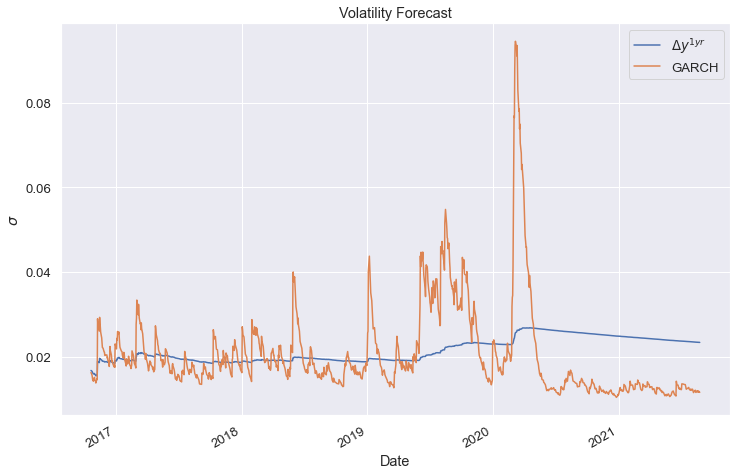

In [17]:
(var**.5).plot()

plt.ylabel(r'$\sigma$')
plt.title('Volatility Forecast')
plt.show()

#### 4. Given only the volatility prediction plot, would you expect high volatility in the bond markets in 2020? What about in 2021? Which model do you think performed better when it came to predicting daily volatility?

Given by how much the expanding volatility prediction jumps over the course of 2020, we expect high volatility in the bond markets for the first part of 2020. The subsequent consistent decrease of the expanding prediction suggests much lower volatility in latter part of 2020 and all of 2021. The GARCH prediction suggests the same scenario. GARCH volatility predictions are high for the first part of 2020 and then very low in the later stages of 2020 and in 2021. 

We can be confident GARCH performed much better, as it will excel in time periods where volatility clusters. In the first half of 2020 we have high volatility for an extended period of time, and then from the second half of 2020 onwards we have seen low volatility. As GARCH adjusts predictions based on recent vol, it will predict significantly more accurate in time periods such as this. 

We expect these movements not just in the treasury bond markets but also in the bond market as a whole to some degree, due to the fact that part of the yields of many bonds can be attributed to a risk free return (the treasury yield).

## Forward Step Regression

In [18]:
y = returns['TSLA'].to_frame('TSLA')

x = returns.copy().drop(columns = 'TSLA')

x.head()

,AAPL,C,F,MSFT,NFLX,PYPL,T,WMT,XOM
Date,,,,,,,,,
2016-01-04,0.000855,-0.011981,-0.008517,-0.012257,-0.038643,-0.040055,-0.001744,0.002610,-0.006286
2016-01-05,-0.025059,-0.005281,-0.017895,0.004562,-0.020917,-0.012662,0.006987,0.023755,0.008521
2016-01-06,-0.019570,-0.014550,-0.044461,-0.018165,0.093071,-0.009618,-0.001466,0.010013,-0.008321
2016-01-07,-0.042205,-0.051077,-0.031274,-0.034783,-0.026513,-0.025015,-0.016148,0.023289,-0.016006
2016-01-08,0.005288,-0.030068,-0.012598,0.003067,-0.027671,-0.013281,0.000895,-0.022913,-0.020202


#### 1. Build an algorithm to select our final 5 factor model and report the coefficients

In [19]:
coefs = []
securities = list(x.columns)

### Stop when we have 5 coefficients
while len(coefs) < 5:
    ### Set an initial max R2
    max_r2 = ('Initial', -np.inf)
    
    ### Loop through the securities that are not coefficients yet
    for security in securities:   
        ### Temporary regression to run and check R2
        temp_coefs = coefs + [security]

        ### Run the regression and grab R2
        x_current = sm.add_constant(x[temp_coefs])
        r2 = sm.OLS(y, x_current).fit().rsquared
        
        ### Keep track of the current max R2 and temporary coefficient
        if r2 > max_r2[1]:
            max_r2 = (security, r2)
    
    ### When we have a coefficient to add:
    ### We remove it from the coefficients we want to test and add it to the coefficient list
    securities.remove(max_r2[0])
    coefs.append(max_r2[0])

In [20]:
x_current = sm.add_constant(x[coefs])
sm.OLS(y, x_current).fit().params.to_frame('Parameters')

,Parameters
const,0.001102
MSFT,0.227436
AAPL,0.273976
NFLX,0.189439
F,0.200599
PYPL,0.238431


#### 2. What security is most correlated to TSLA? Can we know this from our final model?

In [21]:
returns.corr().drop(index = 'TSLA')['TSLA'].to_frame('TSLA').sort_values('TSLA', ascending = False)

,TSLA
MSFT,0.415308
AAPL,0.400170
PYPL,0.390500
NFLX,0.331521
C,0.273085
F,0.259295
XOM,0.199947
WMT,0.156898
T,0.132017


MSFT is the highest correlated to TSLA. 

In [22]:
sm.OLS(y, x_current).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   TSLA   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     82.72
Date:                Thu, 16 Sep 2021   Prob (F-statistic):           4.46e-76
Time:                        12:57:52   Log-Likelihood:                 2793.1
No. Observations:                1383   AIC:                            -5574.
Df Residuals:                    1377   BIC:                            -5543.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.268      0.205      -0.001       0.003
MSFT           0.2274      0.085      2.672      0.008       0.060       0.394
AAPL           0.2740      0.068      4.041      0.000       0.141       0.407
NFLX           0.1894      0.041      4.674      0.000       0.110       0.269
F              0.2006      0.042      4.737      0.000       0.118       0.284
PYPL           0.2384      0.057      4.213      0.000       0.127       0.349
==============================================================================
Omnibus:                      196.449   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1441.797
Skew:                           0.425   Prob(JB):                         0.00
Kurtosis:                       7.929   Cond. No.                         111.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We do not know this from running our final 5 factor regression. As can seen from the above regression summary we cannot conclude that MSFT is the most correlated to TSLA. 

We know that MSFT is that most correlated to TSLA because it is the first coefficient we select. We know that in a univariate regression to explain the variation of TSLA, MSFT had the highest correlation, as that is the methodology for our model. 

#### 3. Report $R^{2}$ of the final model

In [23]:
print('Final Model R-squared: ' + str(round(sm.OLS(y, x_current).fit().rsquared, 3)))

Final Model R-squared: 0.231


#### 4. What may be some potential complications of this model?

- Number of coefficients & multicollinearity: We arbitrarily set a number of coefficients without doing any analysis to see if that is the appropriate amount of coefficients. For example, perhaps a model with 2 factors or 6 factors would perform better. Furthermore, our coefficients are correlated to each other and our covariance matrix is not robust as statsmodels warns us. We do not account for multicollinearity.   
- We are just fitting our model in sample. We do no cross validation or out of sample testing.

In [24]:
round(returns.corr(), 2)

,AAPL,C,F,MSFT,NFLX,PYPL,T,TSLA,WMT,XOM
AAPL,1.00,0.45,0.32,0.71,0.46,0.60,0.34,0.40,0.34,0.36
C,0.45,1.00,0.61,0.49,0.24,0.40,0.52,0.27,0.23,0.66
F,0.32,0.61,1.00,0.34,0.15,0.27,0.44,0.26,0.16,0.51
MSFT,0.71,0.49,0.34,1.00,0.52,0.69,0.37,0.42,0.39,0.38
NFLX,0.46,0.24,0.15,0.52,1.00,0.44,0.14,0.33,0.24,0.14
PYPL,0.60,0.40,0.27,0.69,0.44,1.00,0.22,0.39,0.31,0.29
T,0.34,0.52,0.44,0.37,0.14,0.22,1.00,0.13,0.35,0.50
TSLA,0.40,0.27,0.26,0.42,0.33,0.39,0.13,1.00,0.16,0.20
WMT,0.34,0.23,0.16,0.39,0.24,0.31,0.35,0.16,1.00,0.23
XOM,0.36,0.66,0.51,0.38,0.14,0.29,0.50,0.20,0.23,1.00
